# Ressources

HPI Moodle / Week 11 notebook (data loaders etc.)

https://www.youtube.com/watch?v=PXOzkkB5eH0 (Dataset class)

https://www.youtube.com/watch?v=jPMO_btQcvY <- good tutorial!

#### Loading our custom dataset:
Pytorch Dataset Docs:
https://pytorch.org/vision/stable/datasets.html

Example Code:
https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb

In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.datasets.vision import StandardTransform
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline 
import json
import os

import SimpleITK as sitk

# Train and Test Dataset classes

In [2]:
class BraTS_TrainingDataset():
    def __init__(self, path):
        self.path = path # this should be the root dir for extracted files
        self.imgTr_dir = os.path.join(path, 'imagesTr')
        self.labelsTr_dir = os.path.join(path, 'labelsTr')
        
        print(self.imgTr_dir)
        print(self.labelsTr_dir)
        
        self.imagesTr = []
        self.labelsTr = []
        
        self.imagesTr_paths = []
        self.labelsTr_paths = []
        
        for img, label in zip(os.listdir(self.imgTr_dir), os.listdir(self.labelsTr_dir)):
            self.imagesTr.append(img)
            self.labelsTr.append(label)
        
    def __getitem__(self, idx):
        """
        Loads and returns a single sample in the form of a dictionary
        with keys 'image' and 'label'.
        The function returns the sample at the given index (idx)
        by finding the path and returning the numpy array.
        """
        # load image
        img_filename = self.imagesTr[idx]
        img_path = os.path.join(self.imgTr_dir, img_filename)
        img = np.load(img_path)
        
        # load label
        label_filename = self.labelsTr[idx]
        label_path = os.path.join(self.labelsTr_dir, label_filename)
        label = np.load(label_path)
        
        item = {
            'image': img,
            'label': label
        }
        return item
    
    def __len__(self):
        """
        Returns the number of training-files and checks
        if it is equal to the number of training-labels.
        """
        assert len(self.imagesTr) == len(self.labelsTr)
        return len(self.imagesTr)

In [3]:
class BraTS_TestDataset():
    def __init__(self, path, device='cpu'):
        self.path = path # this should be the root dir for extracted files
        self.imgTs_dir = os.path.join(path, 'imagesTs')
        
        print(self.imgTs_dir)
        
        self.imagesTs = []
        self.imagesTs_paths = []
        
        for img in os.listdir(self.imgTs_dir):
            self.imagesTs.append(img)
            
    def __getitem__(self, idx):
        """
        Loads and returns a single sample in the form of a dictionary
        with keys 'image' and 'label'.
        The function returns the sample at the given index (idx)
        by finding the path and returning the numpy array.
        """
        # load test image
        img_filename = self.imagesTs[idx]
        img_path = os.path.join(self.imgTs_dir, img_filename)
        img = np.load(img_path)
        return img
    
    def __len__(self):
        """
        Returns the number of test-files.
        """
        return len(self.imagesTs)

In [4]:
# PATH
dataset_path = '/media/z/Ubuntu-Storage/BT_Segmentation_Project/Task01_BrainTumour/extracted/'

train_data = BraTS_TrainingDataset(dataset_path)
test_data = BraTS_TestDataset(dataset_path)

/media/z/Ubuntu-Storage/BT_Segmentation_Project/Task01_BrainTumour/extracted/imagesTr
/media/z/Ubuntu-Storage/BT_Segmentation_Project/Task01_BrainTumour/extracted/labelsTr
/media/z/Ubuntu-Storage/BT_Segmentation_Project/Task01_BrainTumour/extracted/imagesTs


In [5]:
# test the __getitem__ function
item = train_data.__getitem__(1)
assert item['image'].shape == (4, 155, 240, 240)
assert item['label'].shape == (155, 240, 240)

# dataset length
print('number of training samples:', train_data.__len__())

number of training samples: 484


In [6]:
# note: you can try 2 workers or more
trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=2, shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(
    test_data, batch_size=2, shuffle=True, num_workers=0)

In [7]:
train_iter = iter(trainloader)
test_iter = iter(testloader)

sample_batch = train_iter.next()
print(sample_batch['image'].shape)
print(sample_batch['label'].shape)

torch.Size([2, 4, 155, 240, 240])
torch.Size([2, 155, 240, 240])


In [8]:
def plot_batch(batch, num_rows=2, height=70):
    
    plt.clf()
    fig, ax_array = plt.subplots(num_rows, 5, figsize=(12,6), 
                                 gridspec_kw = {'wspace':0, 'hspace':0})
    
    for i, ax in enumerate(fig.axes):
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        for row in range(num_rows):
            x = batch['image'][row]
            y = batch['label'][row]
            
            # modalities
            indices = [col_idx + (5*row) for col_idx in range(4)]
            if i in indices:
                ax.imshow(x[i%5, height, :, :], cmap="gray", origin="lower")
                
            # label
            if i == (5*row + 4):
                ax.imshow(y[height, :, :], cmap="gray", origin="lower")
        
    
    plt.show()
    plt.close()

<Figure size 432x288 with 0 Axes>

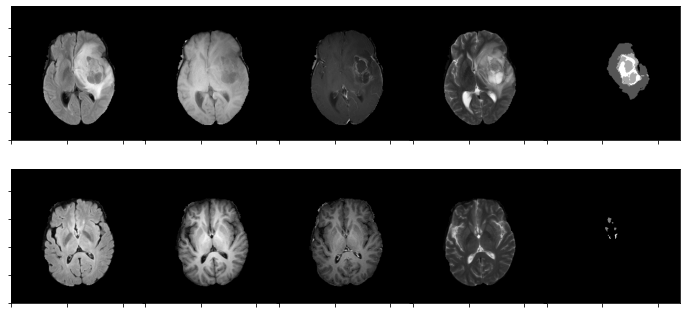

In [9]:
sample_batch = train_iter.next()
plot_batch(sample_batch, num_rows=2, height=75)